## Using DataLoader and Dataset

We are using the fashion mnist dataset.
https://pytorch.org/docs/master/torchvision/datasets.html



In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device('cpu')
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])])


# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, 
                          train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

In [3]:
#flatten x_train 60000x28x28
x_train = trainset.train_data.view(trainset.train_data.shape[0], -1).float()
y_train = trainset.train_labels
print(x_train.shape, y_train.shape)

torch.Size([60000, 784]) torch.Size([60000])


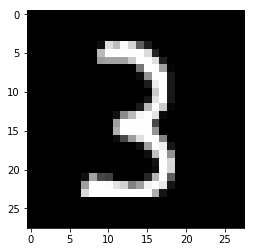

In [4]:
%matplotlib inline

from matplotlib import pyplot
import numpy as np
# each row of x_train conataines a flattend images, we need to reshape it to 28x28 
pyplot.imshow(x_train[49948].reshape((28,28)), cmap="gray")

We can use `Dataloader` to generate and iterate over batches. A `Dataloader` can be created from any `Dataset`, with an additional parameter `batch_size` that defines the size of the minibatches. 

In [5]:
from torch.utils.data import DataLoader
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
train_batches = iter(trainloader)
images, labels = train_batches.next()
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


## Using torch.nn.functional
Pytroch provides several activation and loss functions in the `torch.nn.functional` module, By convention, this is imported into the namspace `F`.

Since we are using negative log likelihood loss and log softmax activation, then Pytorch provides a single function F.cross_entropy that combines the two. So we can even remove the activation function from our model.

In [6]:
import torch.nn.functional as F
loss_func = F.cross_entropy

def model(xb): return xb @ weights + bias

In [7]:
import math
weights = torch.randn(784,10)/math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)
loss_func(model(x_train), y_train)

tensor(138.8269, grad_fn=<NllLossBackward>)

## Using torch.nn.Module
We'll use nn.Module and nn.Parameter, for a clearer and more concise training loop. We subclass nn.Module (which itself is a class and able to keep track of state). In this case, we want to create a class that holds our weights, bias, and method for the forward step. nn.Module has a number of attributes and methods (such as `.parameters()` and `.zero_grad()`) which we will be using.

In [8]:
from torch import nn
class Logistic_mnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784,10)/math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb): return xb @ self.weights + self.bias

In [9]:
model = Logistic_mnist()
loss_func(model(x_train), y_train)

tensor(115.1345, grad_fn=<NllLossBackward>)

We can simplify training using `Dataloader` and `Logistic_minist` model. Here we will define a function `fit()` for that purpose.

In [10]:
def fit(model, dataloader, epochs, lr):
    for epoch in range(epochs):
        for x_train, y_train in dataloader:
            x_train = x_train.view(x_train.shape[0], -1)
            preds = model(x_train)
            loss = loss_func(preds, y_train)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [12]:
lr = 0.5   # learning rate
epochs = 3 # how many epochs to train for
model = Logistic_mnist()
dataloader = DataLoader(trainset, batch_size=64, shuffle=True)

fit(model, dataloader, epochs, lr)

## Using nn.Linear
Using predefined `Linear` for the linear layer, simplifies model definition and `fit()` will run faster. We will also flatten the input for the linear layer in the `forward()` method.
So the input should have size `64x1x28x28` which will be handy when we add a convolutional layer.

In [23]:
class Logistic_mnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(784,10)
        
    def forward(self, x): 
        #flatten x before linear layer
        x = x.view(x.shape[0], -1)
        return self.fc(x)
    
def fit(model, dataloader, epochs, lr):
    for epoch in range(epochs):
        for x_train, y_train in dataloader:
            preds = model(x_train)
            loss = loss_func(preds, y_train)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [24]:
lr = 0.5   # learning rate
epochs = 3 # how many epochs to train for
model = Logistic_mnist()

fit(model, dataloader, epochs, lr)

## Using optim

Pytorch also has a package with various optimization algorithms, torch.optim. We can use the step method from our optimizer to take a forward step, instead of manually updating each parameter.

In [31]:
from torch import optim

def get_model(lr):
    model = Logistic_mnist()
    return model, optim.SGD(model.parameters(), lr=lr)

def fit(model, opt, dataloader, epochs):
    for epoch in range(epochs):
        for x_train, y_train in dataloader:
            preds = model(x_train)
            loss = loss_func(preds, y_train)
            
            loss.backward()
            opt.step()
            opt.zero_grad()

In [32]:
lr = 0.5
epochs = 3
model, opt = get_model(lr)
fit(model, opt, dataloader, epochs)

## Validation
It is important to use separate data sets for training and validation. Doing so, we will be able to determine if we are overfitting. Also, shuffling of the training data is important to reduce the correlation between batches, wheras this is not necessary for the validation set.

In [35]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device('cpu')

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])])
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, 
                          train=True, transform=transform)

train_dl = DataLoader(trainset, batch_size=64)
validationset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, 
                          train=False, transform=transform)
validation_dl = DataLoader(validationset, batch_size=128)

Be aware of using `model.train()` and `model.eval()` in the `fit()` function!

By default all the modules are initialized to train mode (self.training = True). Some layers might have different behavior during train/and evaluation (like BatchNorm, Dropout) so setting it matters.

In [42]:
import torch
import torch.nn.functional as F
from torch import optim

def get_model(lr):
    model = Logistic_mnist()
    return model, optim.SGD(model.parameters(), lr=lr)

def calculate_loss(model, loss_func, x_train, y_train, opt=None):
    loss = loss_func(model(x_train), y_train)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(x_train)

def fit(model, opt, loss_func, train_dl, validation_dl, epochs):
    for epoch in range(epochs):
        model.train()
        for x_train, y_train in train_dl:
            calculate_loss(model, loss_func, x_train, y_train, opt)
        
        model.eval()
        with torch.no_grad():
            losses, nums = \
            zip(*[calculate_loss(model, loss_func, x, y) for x, y in validation_dl])
        val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
        
        print(epoch, val_loss)
    
loss_func = F.cross_entropy
lr = 0.5
epochs = 10
model, opt = get_model(lr)
fit(model, opt, loss_func, train_dl, validation_dl, epochs)

0 10.357490782928467
1 5.42783166809082
2 5.9633808494567875
3 5.46928278503418
4 6.572009448242188
5 5.078942433929443
6 4.712965372085571
7 6.043066973876953
8 5.022225035858154
9 5.165457396316528


In [56]:
a = [1,2,3]
b = [1,10,100]
c = [4,5,6,7]
r = zip(a,b,c)
for i in r:
    print(i)
    
vls = [(1,10), (2,20), (3,30)]
rs =zip(*vls)
rs = zip((1,10), (2,20), (3,30))
print(rs)
for j in rs:
    print(j)

(1, 1, 4)
(2, 10, 5)
(3, 100, 6)
(1, 2, 3)
(10, 20, 30)
